In [1]:
#Import thư viện
import os, random, shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

import torch
import torch.nn as nnx
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.models import vgg16, VGG16_Weights

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from io import BytesIO
from tqdm import tqdm
from tqdm.notebook import tqdm
import pickle


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#xác định thiết bị để sử dụng CPU

In [3]:
#Chia dataset thành train/val/test
def split_data(source_dir, dest_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    files = [f for f in os.listdir(source_dir) if f.endswith(".png") or f.endswith(".jpg")]
    random.shuffle(files)
    n_total = len(files)
    n_train = int(n_total * train_size)
    n_val = int(n_total * val_size)
    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for folder_name, file_list in zip(["train","val","test"], [train_files,val_files,test_files]):
        folder_path = os.path.join(dest_dir, folder_name)
        os.makedirs(os.path.join(folder_path, os.path.basename(source_dir)), exist_ok=True)
        for f in file_list:
            shutil.copy(os.path.join(source_dir,f), os.path.join(folder_path, os.path.basename(source_dir), f))

source_normal = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"
source_tb     = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis"
dest_dir = "/kaggle/working/data"

split_data(source_normal, dest_dir)
split_data(source_tb, dest_dir)

#khai báo đường dẫn
train_dir = os.path.join(dest_dir,"train")
val_dir   = os.path.join(dest_dir,"val")
test_dir  = os.path.join(dest_dir,"test")

In [4]:
#Data Augmentation (Tiền xử lý dữ liệu)
IMG_SIZE = 224
BATCH_SIZE = 64

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9,1.1)),
    transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Số batch train: {len(train_loader)}, số batch val: {len(val_loader)}, số batch test: {len(test_loader)}")
print(f"Số ảnh train: {len(train_loader.dataset)}, val: {len(val_loader.dataset)}, test: {len(test_loader.dataset)}")

class_names = train_dataset.classes
num_classes = len(class_names)


Số batch train: 46, số batch val: 10, số batch test: 10
Số ảnh train: 2939, val: 630, test: 631


In [5]:
WEIGHT_PATH = "/kaggle/input/vgg16-pretrained-weights/vgg16-397923af.pth"
state_dict = torch.load(WEIGHT_PATH, map_location="cpu")

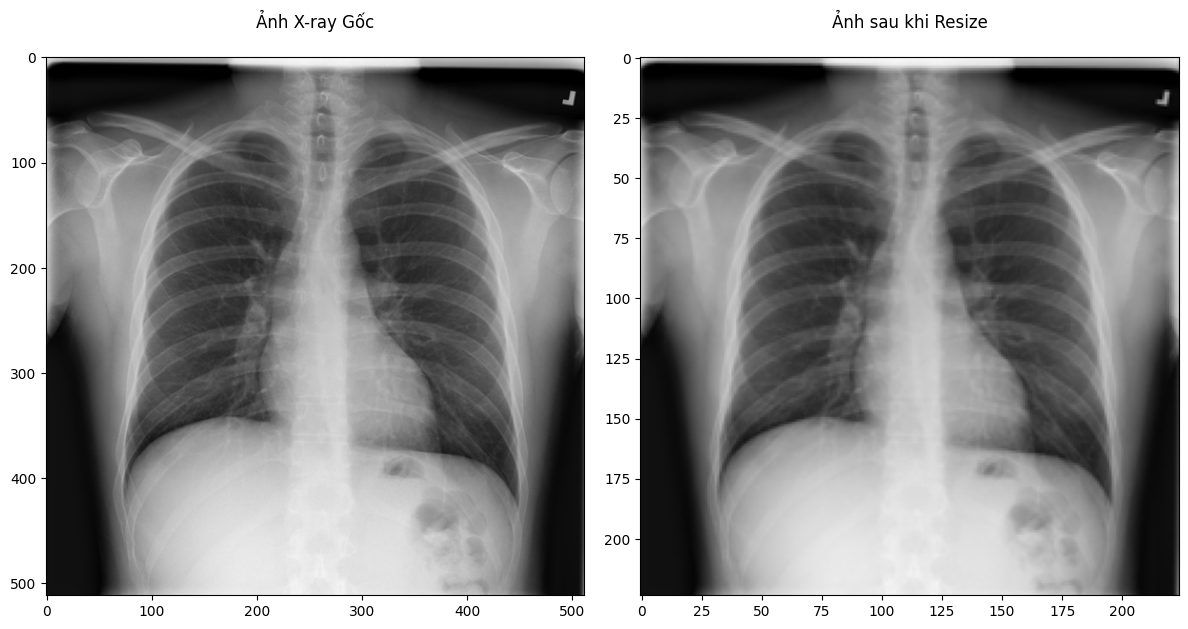

In [6]:
sample_path = train_dataset.samples[0][0] 
img_original = Image.open(sample_path)

img_resized = img_original.resize((224, 224))

plt.figure(figsize=(12, 6))

# Bên trái: Ảnh gốc
plt.subplot(1, 2, 1)
plt.imshow(img_original, cmap='gray')
plt.title(f"Ảnh X-ray Gốc\n", fontsize=12)
plt.axis('on') 

# Bên phải: Ảnh sau khi Resize
plt.subplot(1, 2, 2)
plt.imshow(img_resized, cmap='gray')
plt.title(f"Ảnh sau khi Resize\n", fontsize=12)
plt.axis('on')

plt.tight_layout()

# 4. LƯU ẢNH XUỐNG FILE ĐỂ TẢI VỀ
plt.savefig('so_sanh_resize.png', dpi=300)
plt.show()

In [7]:
# Xây dựng VGG16 gốc
model_orig = models.vgg16(weights=None)
model_orig.load_state_dict(state_dict)

# Freeze toàn bộ backbone
for param in model_orig.features.parameters():
    param.requires_grad = False

# Classifier đơn giản 
model_orig.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

model_orig = model_orig.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_orig = optim.Adam(
    filter(lambda p: p.requires_grad, model_orig.parameters()), lr=1e-4
)


In [8]:
#Xây dựng VGG16 cải tiến (BN, Dropout, Fine-tune)
model_improve = models.vgg16(weights=None)
model_improve.load_state_dict(state_dict)

# Freeze backbone
for param in model_improve.features.parameters():
    param.requires_grad = False

# Fine-tune nhẹ block cuối 
for param in model_improve.features[-4:].parameters():
    param.requires_grad = True

# Classifier cải tiến (BatchNorm + Dropout)
model_improve.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

model_improve = model_improve.to(device)

optimizer_imp = optim.Adam(
    filter(lambda p: p.requires_grad, model_improve.parameters()), lr=1e-4
)


In [9]:
def train_model(model, train_loader, val_loader,criterion, optimizer, epochs=5, patience=2):
    best_loss = float('inf')
    counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()

        running_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(best_model)
    return model, history


In [10]:
#Load lại khi bị ngắt
#checkpoint = torch.load("/kaggle/working/checkpoint_latest.pth", map_location=device)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#start_epoch = checkpoint['epoch'] + 1
#history = checkpoint['history']


In [11]:
#Train VGG16 gốc
model_orig, history_orig = train_model(
    model_orig, train_loader, val_loader,
    criterion, optimizer_orig,
    epochs=5, patience=2
)



Epoch 1/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9115 | Val Acc: 0.9619

Epoch 2/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9772 | Val Acc: 0.9730

Epoch 3/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9905 | Val Acc: 0.9762

Epoch 4/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9929 | Val Acc: 0.9810

Epoch 5/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9925 | Val Acc: 0.9825


In [12]:
# Lưu VGG16 gốc (mô hình + lịch sử)
torch.save(model_orig, "/kaggle/working/vgg16_original_full.pth")
with open("/kaggle/working/history_orig.pkl", "wb") as f:
    pickle.dump(history_orig, f)

In [13]:
#Train VGG16 Cải tiến
model_improve, history_improve = train_model(
    model_improve, train_loader, val_loader,
    criterion, optimizer_imp,
    epochs=5, patience=2
)



Epoch 1/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.8734 | Val Acc: 0.9810

Epoch 2/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9663 | Val Acc: 0.9873

Epoch 3/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9826 | Val Acc: 0.9873

Epoch 4/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9895 | Val Acc: 0.9921

Epoch 5/5


  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc: 0.9901 | Val Acc: 0.9905


In [14]:
# Lưu VGG16 cải tiến (mô hình + lịch sử)
torch.save(model_improve, "/kaggle/working/vgg16_improved_full.pth")
with open("/kaggle/working/history_improve.pkl", "wb") as f:
    pickle.dump(history_improve, f)

In [15]:
model_orig = torch.load(
    "/kaggle/input/modelvhis6/vgg16_original_full.pth",
    map_location=device,
    weights_only=False
)
model_orig.eval()

model_improve = torch.load(
    "/kaggle/input/modelvhis6/vgg16_improved_full.pth",
    map_location=device,
    weights_only=False
)
model_improve.eval()


with open("/kaggle/input/modelvhis6/history_orig.pkl", "rb") as f:
    history_orig = pickle.load(f)

with open("/kaggle/input/modelvhis6/history_improve.pkl", "rb") as f:
    history_improve = pickle.load(f)


In [16]:
#METRICS EVALUATION
def evaluate_model(model, dataloader, device):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall    = recall_score(y_true, y_pred, average='binary')
    f1        = f1_score(y_true, y_pred, average='binary')

    return accuracy, precision, recall, f1


#SO SÁNH 2 MÔ HÌNH
acc_o, pre_o, rec_o, f1_o = evaluate_model(model_orig, test_loader, device)
acc_i, pre_i, rec_i, f1_i = evaluate_model(model_improve, test_loader, device)

print("KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST\n")

print("VGG16 gốc")
print(f"Accuracy : {acc_o:.4f}")
print(f"Precision: {pre_o:.4f}")
print(f"Recall   : {rec_o:.4f}")
print(f"F1-score : {f1_o:.4f}")

print("\nVGG16 cải tiến")
print(f"Accuracy : {acc_i:.4f}")
print(f"Precision: {pre_i:.4f}")
print(f"Recall   : {rec_i:.4f}")
print(f"F1-score : {f1_i:.4f}")


#BẢNG SO SÁNH 
import pandas as pd

compare_table = pd.DataFrame({
    "Model": ["VGG16 gốc", "VGG16 cải tiến"],
    "Accuracy":  [acc_o, acc_i],
    "Precision": [pre_o, pre_i],
    "Recall":    [rec_o, rec_i],
    "F1-score":  [f1_o, f1_i]
})

compare_table


KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST

VGG16 gốc
Accuracy : 0.9905
Precision: 0.9630
Recall   : 0.9811
F1-score : 0.9720

VGG16 cải tiến
Accuracy : 0.9952
Precision: 0.9905
Recall   : 0.9811
F1-score : 0.9858


,Model,Accuracy,Precision,Recall,F1-score
0,VGG16 gốc,0.990491,0.962963,0.981132,0.971963
1,VGG16 cải tiến,0.995246,0.990476,0.981132,0.985782


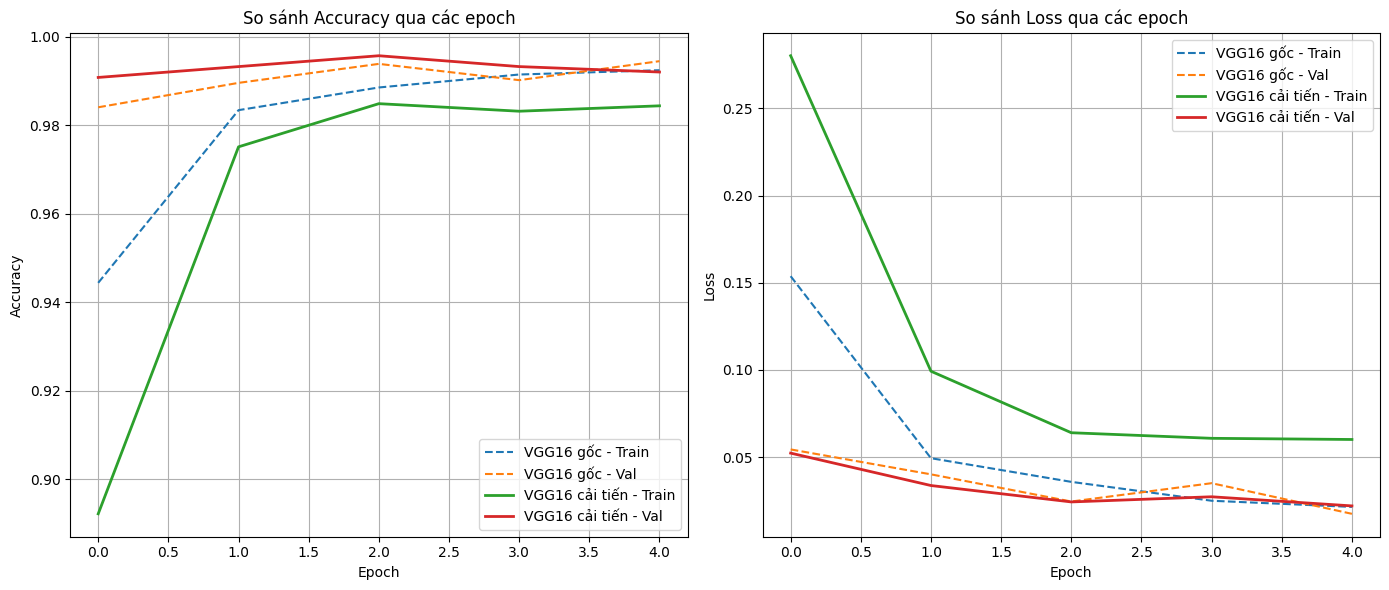

In [17]:
# PLOT ACCURACY & LOSS
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_orig['train_acc'], label='VGG16 gốc - Train', linestyle='--')
plt.plot(history_orig['val_acc'], label='VGG16 gốc - Val', linestyle='--')
plt.plot(history_improve['train_acc'], label='VGG16 cải tiến - Train', linewidth=2)
plt.plot(history_improve['val_acc'], label='VGG16 cải tiến - Val', linewidth=2)
plt.title('So sánh Accuracy qua các epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_orig['train_loss'], label='VGG16 gốc - Train', linestyle='--')
plt.plot(history_orig['val_loss'], label='VGG16 gốc - Val', linestyle='--')
plt.plot(history_improve['train_loss'], label='VGG16 cải tiến - Train', linewidth=2)
plt.plot(history_improve['val_loss'], label='VGG16 cải tiến - Val', linewidth=2)
plt.title('So sánh Loss qua các epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.grid(True)

plt.tight_layout()

# DÒNG QUAN TRỌNG ĐỂ TẢI ẢNH:
plt.savefig('ACCURACYvLOSS.png', dpi=300)

plt.show()

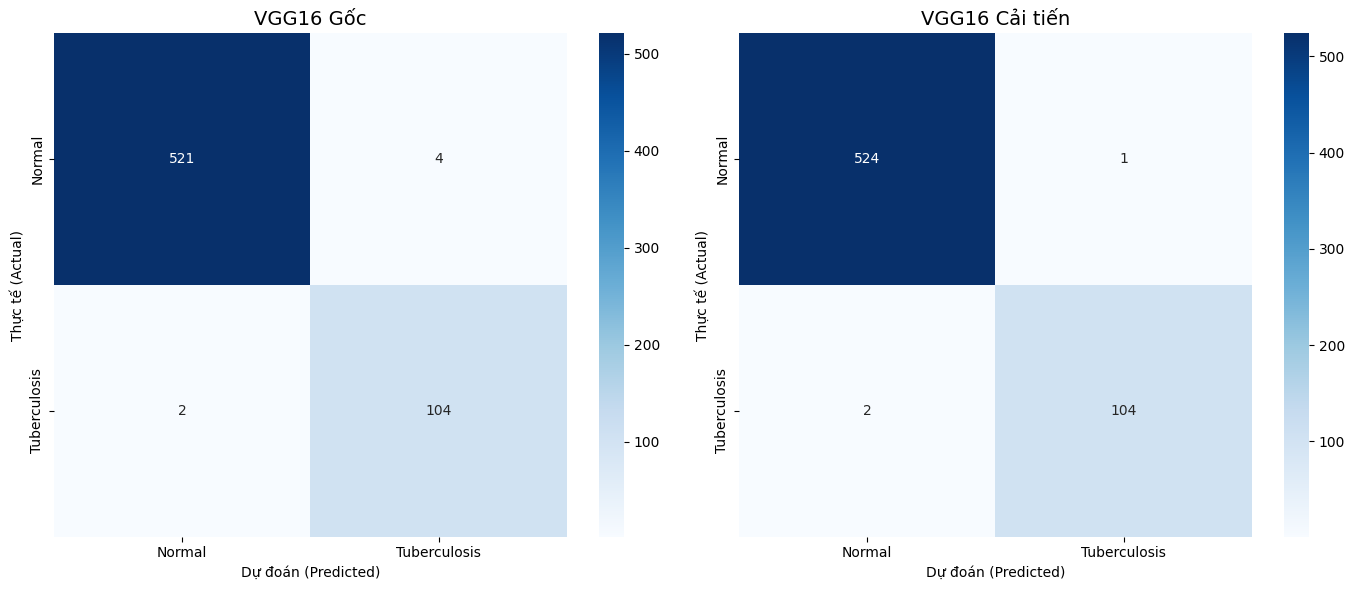

In [18]:
#CONFUSION MATRIX
def plot_dual_confusion_matrix(model_orig, model_improve, dataloader, class_names):
    models = [model_orig, model_improve]
    titles = ["VGG16 Gốc", "VGG16 Cải tiến"]
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for i, model in enumerate(models):
        y_true, y_pred = [], []
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.argmax(1).cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cmap='Blues', ax=axes[i])
        
        axes[i].set_title(titles[i], fontsize=14)
        axes[i].set_xlabel('Dự đoán (Predicted)')
        axes[i].set_ylabel('Thực tế (Actual)')

    plt.tight_layout()
    plt.show()

plot_dual_confusion_matrix(model_orig, model_improve, test_loader, class_names)

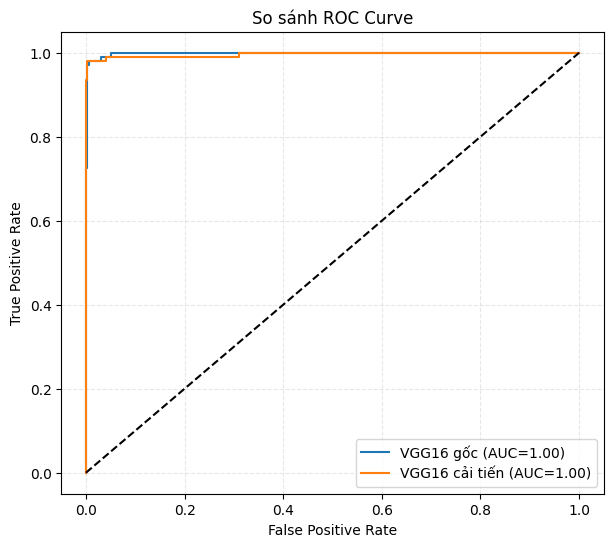

In [19]:
#So sánh ROC
def compare_roc(models, loader, names):
    plt.figure(figsize=(7,6))
    for model, name in zip(models, names):
        y_true, y_prob = [], []
        model.eval()
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                p = F.softmax(model(x), dim=1)[:,1]
                y_true += y.cpu().numpy().tolist()
                y_prob += p.cpu().numpy().tolist()
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")

    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("So sánh ROC Curve")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

compare_roc([model_orig, model_improve], test_loader, ["VGG16 gốc", "VGG16 cải tiến"])


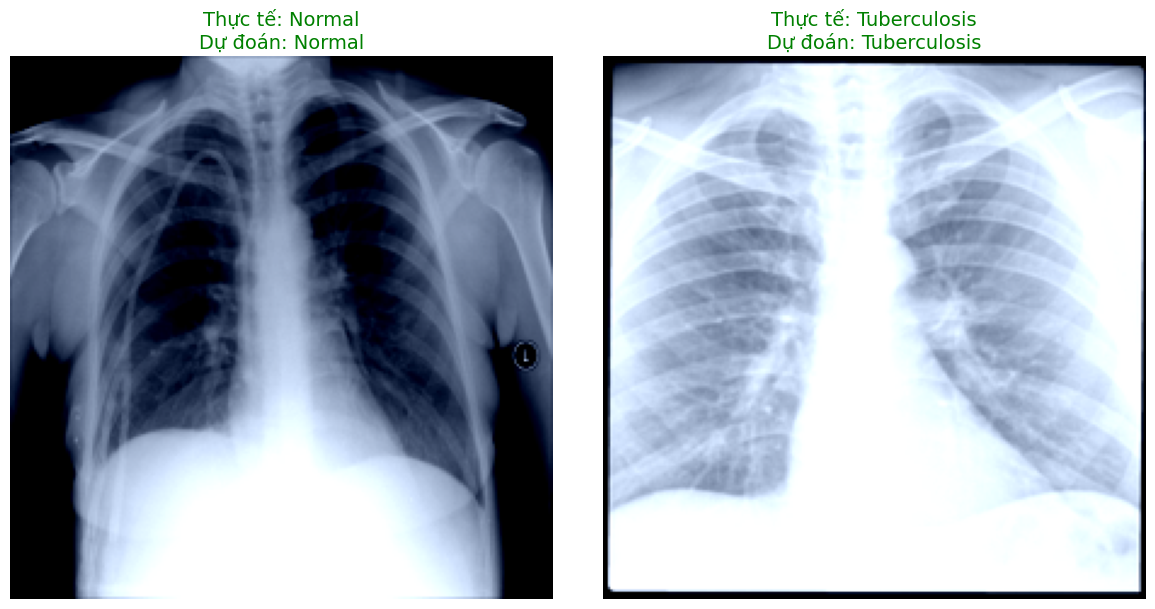

In [20]:
def plot_sample_results(model, dataset, class_names):
    model.eval()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Tìm 1 ảnh thuộc lớp 0 (Normal) và 1 ảnh thuộc lớp 1 (Tuberculosis)
    indices = []
    found_classes = set()
    for i in range(len(dataset)):
        label = dataset.samples[i][1]
        if label not in found_classes:
            indices.append(i)
            found_classes.add(label)
        if len(found_classes) == 2: break

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            # Chuẩn bị ảnh cho model (thêm batch dimension và đưa lên device)
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            
            # Chuyển tensor ảnh về dạng numpy để vẽ (HWC)
            img_display = image.permute(1, 2, 0).cpu().numpy()
            # Unnormalize (nếu bạn có dùng chuẩn hóa lúc transform)
            img_display = np.clip(img_display * 0.5 + 0.5, 0, 1) 

            axes[i].imshow(img_display, cmap='gray')
            color = 'green' if pred.item() == label else 'red'
            axes[i].set_title(f"Thực tế: {class_names[label]}\nDự đoán: {class_names[pred.item()]}", 
                              color=color, fontsize=14)
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('ket_qua_phan_loai_mau.png', dpi=300)
    plt.show()

# Gọi hàm với mô hình cải tiến của bạn
plot_sample_results(model_improve, test_dataset, class_names)

In [21]:
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def predict_image_from_bytes(model, file_bytes, img_size=(224,224)):
    img = Image.open(BytesIO(file_bytes)).convert("RGB")
    img_resized = img.resize(img_size)
    x = transforms.ToTensor()(img_resized).unsqueeze(0)
    x = x.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        probs = nn.functional.softmax(outputs, dim=1)
        idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0, idx].item()
        class_name = class_names[idx]
    return class_name, confidence, img
    

FileUpload(value=(), accept='image/*', description='Upload')

In [22]:
if uploader.value != ():
    file_bytes = uploader.value[0]['content']
    img = Image.open(BytesIO(file_bytes))
    plt.imshow(img); plt.axis("off"); plt.show()
    label_o, conf_o, _ = predict_image_from_bytes(model_orig, file_bytes)
    label_i, conf_i, _ = predict_image_from_bytes(model_improve, file_bytes)
    print("VGG16 gốc:", label_o, round(conf_o*100,2), "%")
    print("VGG16 cải tiến:", label_i, round(conf_i*100,2), "%")